# Mc pricing

**Objectives**
- Shortly reflect on MC theory and risk-neutral pricing theory
- Implement a MC pricer and use it for european calls
- Compare to BS and demonstrate convergence and error
- Apply variance reduction techniques

**References**
- Glasserman


## Imports and configuration

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, lognorm
from option_pricing.params import PricingInputs
from option_pricing.processes import sim_gbm_terminal
from option_pricing.diagnostics.gbm_diagnostics import plot_gbm_terminal_dists

from option_pricing.diagnostics.mc_vs_bs import (
    default_cases, grid_cases,
    compare_table, multi_seed_summary, convergence_table
)
# Some default parameters we will be using later.
params = PricingInputs(
    t=0.0,
    S=100.0,
    K=100.0,
    r=0.02,
    sigma=0.2,
    T=1.0,
)

## Short theory recap

In quantitative finance, \textbf{Monte Carlo (MC)} methods provide a way to price derivatives by approximating payoff expectations taken under a risk-neutral measure. The central idea is that, under standard no-arbitrage assumptions, the discounted value of an option equals the  expectation of its payoff.

### Risk-neutral pricing

Let $V_t$ denote the value at time $t$ of a claim that pays $g(\text{path})$ at maturity $T$, where the payoff may depend on the entire price path (e.g.\ Asian, barrier, lookback options) or only on the terminal value (e.g.\ European options). Then there exists an equivalent  risk-neutral measure (i.e they agree when probabilities are zero) $\mathbb{Q}$ such that
$$
V_t \;=\; \mathbb{E}^{\mathbb{Q}}\!\left[ D(t,T)\, g(\text{path}) \,\middle|\, \mathcal{F}_t \right],
$$
where $D(t,T)$ is the discount factor from $T$ back to $t$. If the instantaneous risk-free interest rate is constant and equal to $r$, then
$$
D(t,T) \;=\; e^{-r(T-t)}.
$$
In particular, at $t=0$,
$$
V_0 \;=\; \mathbb{E}^{\mathbb{Q}}\!\left[ e^{-rT}\, g(\text{path}) \right].
$$

**Example: European call under Black--Scholes**

We will mostly focus on a \textbf{European call} with strike $K$ and maturity $T$, with payoff
$$
g(S_T) \;=\; (S_T-K)^+.
$$
Under the Black--Scholes assumptions (see `03_black_scholes_pricing.ipynb`), the stock price under the risk-neutral measure $\mathbb{Q}$ follows
$$
dS_t \;=\; r S_t\,dt \;+\; \sigma S_t\, dW_t^{\mathbb{Q}}.
$$
Risk-neutral valuation then gives the time-$0$ call price
$$
C_0 \;=\; \mathbb{E}^{\mathbb{Q}}\!\left[e^{-rT}(S_T-K)^+\right].
$$

In this setting, $C_0$ is also available in closed form via the Black--Scholes formula, which we will use as a benchmark for our Monte Carlo estimates.

### Monte Carlo estimator
Define the discounted payoff random variable
$$
X \;:=\; e^{-rT}(S_T-K)^+,
$$
so that the call price can be written as the risk-neutral expectation
$$
C_0 \;=\; \mathbb{E}^{\mathbb{Q}}[X].
$$
By definition, an expectation is the average value of $X$ under $\mathbb{Q}$. Monte Carlo approximates this average by an empirical mean of $N$ i.i.d.\ samples $X^{(1)},\dots,X^{(N)}$:
$$
\widehat{C}_N \;:=\; \frac{1}{N}\sum_{i=1}^N X^{(i)} \;\approx\; \mathbb{E}^{\mathbb{Q}}[X] \;=\; C_0.
$$
Substituting $X^{(i)} = e^{-rT}(S_T^{(i)}-K)^+$ gives
$$
\widehat{C}_N \;=\; e^{-rT}\,\frac{1}{N}\sum_{i=1}^N (S_T^{(i)}-K)^+.
$$

In the Black--Scholes model, the terminal price admits the exact representation
$$
S_T \;=\; S_0 \exp\!\left(\left(r-\tfrac12\sigma^2\right)T + \sigma\sqrt{T}\,Z\right),
\qquad Z \sim \mathcal{N}(0,1).
$$
Thus, the MC workflow for this example is:
  - draw $Z^{(i)} \sim \mathcal{N}(0,1)$ for $i=1,\dots,N$,
  - compute $S_T^{(i)} = S_0 \exp\!\left(\left(r-\tfrac12\sigma^2\right)T + \sigma\sqrt{T}\,Z^{(i)}\right)$,
  - compute payoffs $\left(S_T^{(i)}-K\right)^+$,
  - discount and average to obtain $\widehat{C}_N$.

Finally, Monte Carlo also provides a natural measure of statistical uncertainty. With sample variance
$$
s^2 \;=\; \frac{1}{N-1}\sum_{i=1}^N \left(X^{(i)} - \widehat{C}_N\right)^2,
$$
the standard error is approximately
$$
\mathrm{SE}(\widehat{C}_N) \;\approx\; \frac{s}{\sqrt{N}}.
$$


(We will discuss convergence, error scaling, and confidence intervals in more detail in a dedicated section.)

**Note**
Implementation details
“We use pseudo-random numbers (NumPy) and standard normals to simulate GBM increments, as in Glasserman 2.2–2.3.”

## Monte Carlo as numerical integration

## Simulating terminal prices under GBM

**recal GBM solution**

$$
S_t = S_0 \exp\left(
    \left(\mu - \tfrac{1}{2}\sigma^2\right)t + \sigma W_t
\right).
$$

**code using processes from lib**

`processes.py`, `mc_pricing.py`

Explain why we use `sim_gbm_terminal`

**Maybe hists of simulation**

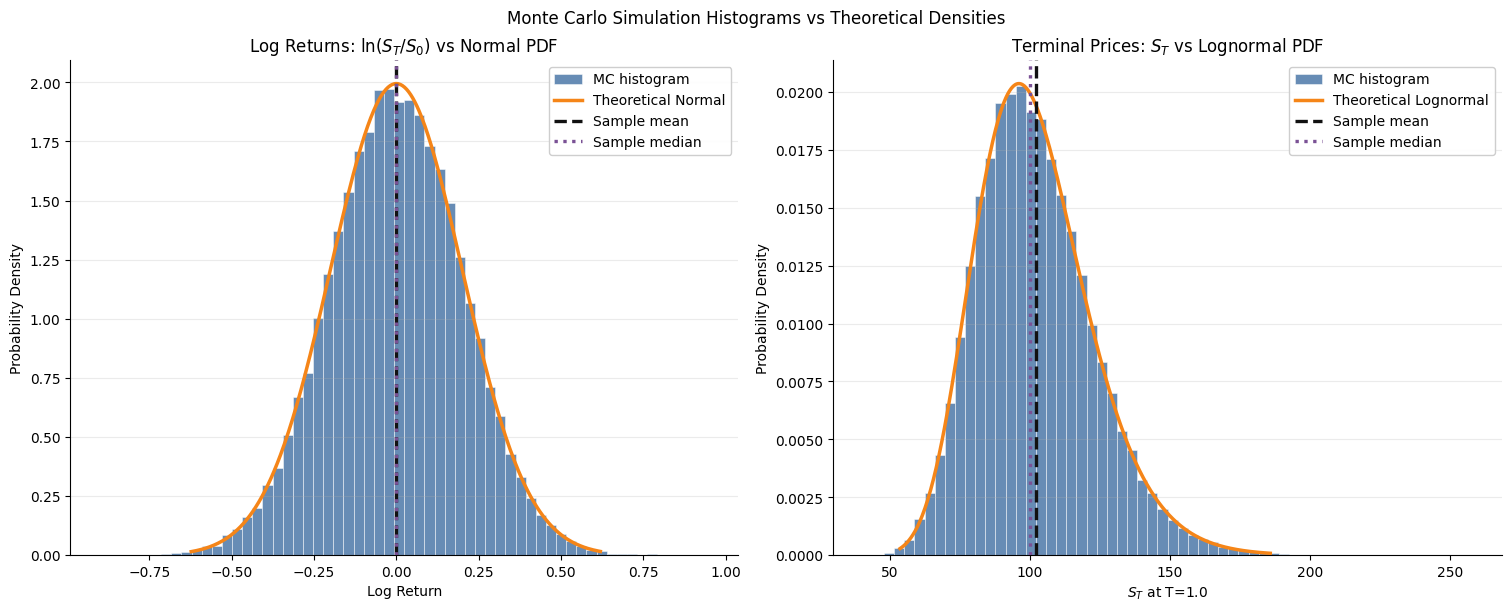

In [13]:

n_paths = 50_000
rng = np.random.default_rng(0)  # fixed seed -> reproducible
S_T = sim_gbm_terminal(n_paths=n_paths, T=params.T, mu=params.r, sigma=params.sigma, S0=params.S, rng=rng)

fig, axes = plot_gbm_terminal_dists(
    S_T,
    S0=params.S,
    r=params.r,
    sigma=params.sigma,
    T=params.T,
    bins=60,
    show_mean=True,
    show_median=True,
)

## Pricing european call using MC
- implement mc_european_call and mc_european_put in the repo and use them here.



- Compare MC price to BS price for some parameter sets.


In [30]:
param_cases = default_cases(params)
table = df = compare_table(
    param_cases,
    n_paths=10_000,
    seed=0,
    per_case_seed=True
)
df[["case", "t", "S", "K", "r", "sigma", "T", "tau", "MC", "SE", "BS", "MC-BS"]]

,case,t,S,K,r,sigma,T,tau,MC,SE,BS,MC-BS
0,Short tau (1w),0.0,100.0,100.0,0.02,0.20,0.019231,0.019231,1.164642,0.016852,1.125552,0.039090
1,High vol (80%),0.0,100.0,100.0,0.02,0.80,1.000000,1.000000,30.581534,0.771025,31.775774,-1.194239
2,Low vol (5%),0.0,100.0,100.0,0.02,0.05,1.000000,1.000000,3.066842,0.036114,3.120691,-0.053849
3,ITM (S=120),0.0,120.0,100.0,0.02,0.20,1.000000,1.000000,23.487194,0.217916,23.742105,-0.254911
4,High rate (10%),0.0,100.0,100.0,0.10,0.20,1.000000,1.000000,13.424432,0.162967,13.269677,0.154756
5,Long tau (5y),0.0,100.0,100.0,0.02,0.20,5.000000,5.000000,22.253855,0.378572,22.022087,0.231768
6,OTM (S=80),0.0,80.0,100.0,0.02,0.20,1.000000,1.000000,1.458459,0.052068,1.427365,0.031094
7,ATM base,0.0,100.0,100.0,0.02,0.20,1.000000,1.000000,8.993184,0.136756,8.916037,0.077146
8,Deep ITM (S=150),0.0,150.0,100.0,0.02,0.20,1.000000,1.000000,52.143307,0.301027,52.124969,0.018337
9,Deep OTM (S=50),0.0,50.0,100.0,0.02,0.20,1.000000,1.000000,0.000000,0.000000,0.001379,-0.001379


- 1 figure: error bar chart (MC-BS with CI bars) for the default cases
- 1 figure: convergence for ATM + deep OTM (or high vol)
- optional table: nicely formatted, fewer columns


- Show error and maybe confidence interval.


- Convergence plot and error vs log(n_paths) plot
    - explain theory of $\frac{1}{\sqrt{N}}$ convergence

## (Optional / Stub) Variance reduction

## Summary and next steps